# Applying DeepLOB model to predict the results of horizon 10 for stock HTO of Athex Exchange.

In [ ]:
# Importing the libraries.
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, CuDNNLSTM
from keras.models import Model
import tensorflow as tf
import keras

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)
print(tf.config.list_physical_devices())

2.9.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Data preparation

In [ ]:
# Functions to prepare the data for the model.
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:, k] - 1
    y = to_categorical(y, 3)
    return x, y


In [ ]:
# Load data
dec_data = np.loadtxt('train_HTO_case1.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.9))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.9)):]
dec_test = np.loadtxt('test_HTO_case1.txt')

k = 0 # Which horizon to use for prediction
T = 100 # The input dimension (time steps)
n_hiddens = 64
checkpoint_filepath = './HTO_deeplob_k0/weights' # Where to save the model weights.

trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)

print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(21498, 100, 40, 1) (21498, 3)
(2301, 100, 40, 1) (2301, 3)
(10946, 100, 40, 1) (10946, 3)


# Model Architecture


In [ ]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
    
    # build the convolutional block
    conv_first1 = Conv2D(16, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(16, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(16, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(32, (1, 1), padding='same')(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(32, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(32, (1, 1), padding='same')(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(32, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(32, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.1, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)
    
    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)  # Change CuDNNLSTM to LSTM

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model
deeplob = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
deeplob.summary()

2024-08-11 16:16:25.393516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 20, 16)  48          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 20, 16)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 20, 16)  1040        ['leaky_re_lu[0][0]']        

/Users/lamprosganias/opt/anaconda3/envs/ML/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Model Training

In [5]:
# Set up the checkpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model
deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN), 
            epochs=50, batch_size=64, verbose=1, callbacks=[model_checkpoint_callback,early_stopping])


Epoch 1/50
336/336 [==============================] - 39s 111ms/step - loss: 1.0376 - accuracy: 0.4369 - val_loss: 1.0250 - val_accuracy: 0.4611
Epoch 2/50
336/336 [==============================] - 41s 121ms/step - loss: 0.9967 - accuracy: 0.4756 - val_loss: 1.0374 - val_accuracy: 0.4542
Epoch 3/50
336/336 [==============================] - 43s 129ms/step - loss: 0.9739 - accuracy: 0.4969 - val_loss: 1.0630 - val_accuracy: 0.4607
Epoch 4/50
336/336 [==============================] - 43s 128ms/step - loss: 0.9618 - accuracy: 0.5063 - val_loss: 1.0131 - val_accuracy: 0.4663
Epoch 5/50
336/336 [==============================] - 44s 132ms/step - loss: 0.9520 - accuracy: 0.5143 - val_loss: 0.9997 - val_accuracy: 0.4763
Epoch 6/50
336/336 [==============================] - 49s 146ms/step - loss: 0.9422 - accuracy: 0.5224 - val_loss: 1.0525 - val_accuracy: 0.4650
Epoch 7/50
336/336 [==============================] - 42s 126ms/step - loss: 0.9359 - accuracy: 0.5277 - val_loss: 1.0405 - val_ac

In [9]:
# Train the model
deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN), 
            epochs=20, batch_size=64, verbose=1, callbacks=[model_checkpoint_callback,early_stopping])

Epoch 1/20
336/336 [==============================] - 38s 112ms/step - loss: 0.6390 - accuracy: 0.7403 - val_loss: 0.7775 - val_accuracy: 0.6532
Epoch 2/20
336/336 [==============================] - 40s 119ms/step - loss: 0.6329 - accuracy: 0.7423 - val_loss: 0.7612 - val_accuracy: 0.6545
Epoch 3/20
336/336 [==============================] - 40s 120ms/step - loss: 0.6341 - accuracy: 0.7410 - val_loss: 0.7813 - val_accuracy: 0.6441
Epoch 4/20
336/336 [==============================] - 43s 129ms/step - loss: 0.6290 - accuracy: 0.7416 - val_loss: 0.7545 - val_accuracy: 0.6662
Epoch 5/20
336/336 [==============================] - 41s 123ms/step - loss: 0.6283 - accuracy: 0.7452 - val_loss: 0.8350 - val_accuracy: 0.6397
Epoch 6/20
336/336 [==============================] - 41s 123ms/step - loss: 0.6210 - accuracy: 0.7475 - val_loss: 0.7630 - val_accuracy: 0.6615
Epoch 7/20
336/336 [==============================] - 42s 125ms/step - loss: 0.6231 - accuracy: 0.7460 - val_loss: 0.7461 - val_ac

# Model Testing

In [ ]:
deeplob.load_weights(checkpoint_filepath)
pred = deeplob.predict(testX_CNN)


print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))

343/343 [==============================] - 9s 26ms/step
accuracy_score: 0.6490955600219258
              precision    recall  f1-score   support

           0     0.7006    0.6597    0.6795      3891
           1     0.5575    0.6519    0.6010      3212
           2     0.6931    0.6360    0.6633      3843

    accuracy                         0.6491     10946
   macro avg     0.6504    0.6492    0.6480     10946
weighted avg     0.6560    0.6491    0.6508     10946



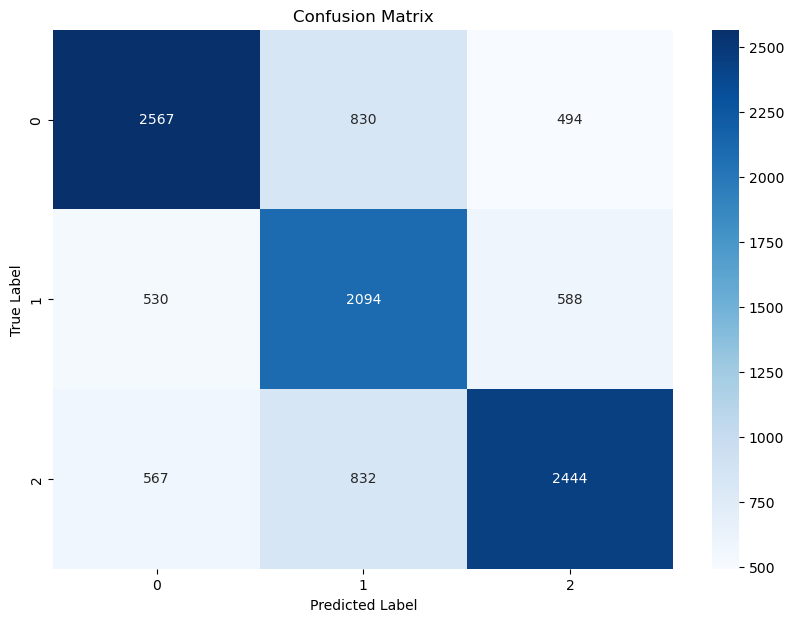

In [ ]:
# Convert one-hot encoded vectors to class labels
true_labels = np.argmax(testY_CNN, axis=1)
predicted_labels = np.argmax(pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)


# Plotting using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()